In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
import random

import sys
sys.path.append("../../../../..")
from earthquakes.quakes_util import custom_geo_distance, is_point_in_bbox, get_earthquakes_in_timespan, find_closest_station, UTCDateTime_to_string, \
    string_to_UTCDateTime, quake_filename_to_UTCDateTime, BadDataException, read_pickle, write_pickle, obtain_data, timeit_context, visualize_sensors_graph, create_weighted_adjacency_quakes, \
    visualize_quakes, resample_data, k_hop_reach, recalls_at_k_hops, precisions_at_k_hops, f1_scores_at_k_hops, compute_metrics_with_growing_radius, compute_metrics_with_growing_radius_v2
from utils.misc_utils import check_create_folder

classToLabel_dict_path = r"C:\Users\gabri\Desktop\new_thesis_project\earthquakes\data\new_dataset_gabriele\packaged\class2label_dict.pickle"
LabelToClass_dict_path = r"C:\Users\gabri\Desktop\new_thesis_project\earthquakes\data\new_dataset_gabriele\packaged\label2class_dict.pickle"

classToLabel_dict = read_pickle(classToLabel_dict_path)
labelToClass_dict = read_pickle(LabelToClass_dict_path)

from definitions import QUAKES_RAW_DATA_PATH
NEW_DATASET_FOLDER = os.path.join(QUAKES_RAW_DATA_PATH, "new_dataset_gabriele")
distances_matrix = np.load(os.path.join(NEW_DATASET_FOLDER, "packaged", "pairwise_distances.npy"))

In [2]:
colors={
    'GTCNN': "forestgreen",
    'LSTM': "goldenrod",
    'GGRNN': "darkred",
    'Random': "fuchsia"
}

In [3]:
# raw_cms_folder = r"C:\Users\gabri\Desktop\new_thesis_project\earthquakes\code\regions\precursor_based\OriginalProblem\runs_quakes_LSTM_w=20_perc=1.0"

# runs_folders = next(os.walk(raw_cms_folder))[1]
# final_raw_cm = np.zeros((45, 45))
# for fold in runs_folders:
#     cm_path = os.path.join(raw_cms_folder, fold, 'cm_tst.npy')
#     cm = np.load(cm_path)
#     final_raw_cm += cm

# print(final_raw_cm.sum())

In [5]:
# get the cm of the raw data experiment
raw_path = r"C:\Users\gabri\Desktop\new_thesis_project\earthquakes\code\regions\precursor_based\OriginalProblem\LSTM_conf_matrices\20200616184054\sum_of_confusion_matrices_15_iters_best.npy"
raw_cm = np.load(raw_path)

print(raw_cm.sum())


# get the cm of the downsampled experiment (original experiment)
downsampled_path = r"C:\Users\gabri\Desktop\exp_earthquakes\original_problem\LSTM_conf_matrices\20200421010224\sum_of_confusion_matrices_15_iters_best.npy"
downsampled_cm = np.load(downsampled_path)

print(downsampled_cm.sum())

print((raw_cm == downsampled_cm).all())

13905
13905
False


In [6]:
def mimic_rnd_confusion_matrix(original_confusion_matrix):
    n_classes = original_confusion_matrix.shape[0]
    random_conf_matrix = np.zeros([n_classes, n_classes])
    
    for cls_index in range(n_classes):
        class_support = sum(original_confusion_matrix[cls_index])
        predictions = np.zeros([n_classes])

        for _ in range(class_support):
            rnd_index = random.randrange(0, n_classes, 1)
            predictions[rnd_index] += 1
        random_conf_matrix[cls_index] = predictions
    return random_conf_matrix

cm_RANDOM = mimic_rnd_confusion_matrix(downsampled_cm)

In [7]:
MIN_RADIUS = 0
MAX_RADIUS = 150

STEP = 5


metrics_down = compute_metrics_with_growing_radius_v2(downsampled_cm, distances_matrix, MIN_RADIUS, MAX_RADIUS, STEP, labelToClass_dict, verbose=False)
metrics_random = compute_metrics_with_growing_radius_v2(cm_RANDOM, distances_matrix, MIN_RADIUS, MAX_RADIUS, STEP, labelToClass_dict, verbose=False)
metrics_raw = compute_metrics_with_growing_radius_v2(raw_cm, distances_matrix, MIN_RADIUS, MAX_RADIUS, STEP, labelToClass_dict, verbose=False)

100%|█████████████████████████████████████████████████████████████████████████████████| 58/58 [00:00<00:00, 312.71it/s]


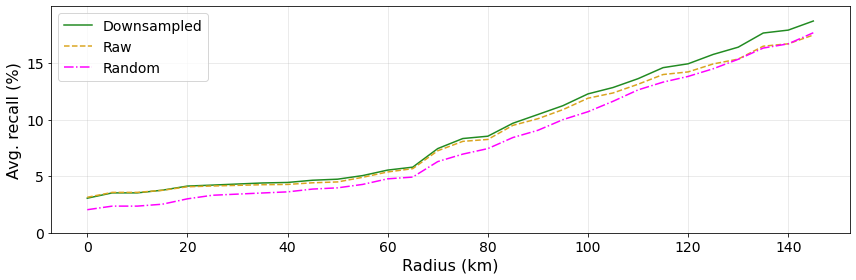

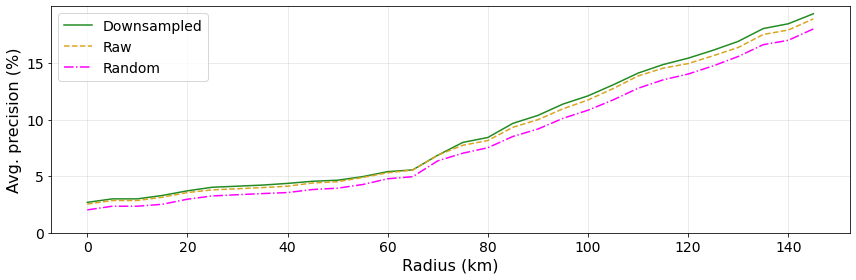

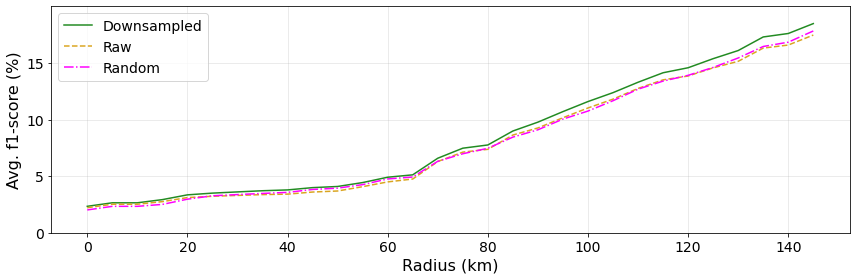

In [17]:
figsize = (12, 4)
LOG_SCALE = False

stations = labelToClass_dict.keys()
for metric in ['recalls', 'precisions', 'f1_scores']:
    down_mean_values = np.mean(np.array([metrics_down[station][metric] for station in stations]), axis=0)
    raw_mean_values = np.mean(np.array([metrics_raw[station][metric] for station in stations]), axis=0)
    RANDOM_mean_values = np.mean(np.array([metrics_random[station][metric] for station in stations]), axis=0)
    
    plt.figure(figsize=figsize)
    
    x_values = np.arange(MIN_RADIUS, MAX_RADIUS, STEP)
    plt.plot(x_values, down_mean_values*100, label="Downsampled", color="forestgreen")
    plt.plot(x_values, raw_mean_values*100, label="Raw", linestyle='--', color="goldenrod")
    plt.plot(x_values, RANDOM_mean_values*100, label="Random", linestyle='-.', color=colors['Random'])

    plt.legend(fontsize=14)
    
    plt.grid(alpha=0.3)
    plt.xlabel("Radius (km)", fontsize=16)
    ylabel = metric[:-1].replace("_", "-")
    plt.ylabel(f"Avg. {ylabel} (%)", fontsize=16)

    if LOG_SCALE:
        plt.yscale("log")
    else:
        max_value = 20
        plt.ylim(0, max_value)
        plt.yticks(range(0, max_value, 5))
#     

    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.tight_layout()
    plt.savefig(f"LSTM_downsampled_vs_raw_avg-{metric}.pdf")
    plt.show()

In [9]:
len(metrics_down['accuracies'])

30

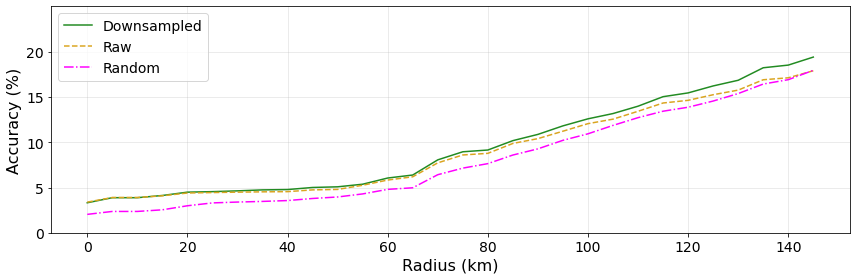

In [16]:
figsize = (12, 4)

plt.figure(figsize=figsize)

x_values = np.arange(MIN_RADIUS, MAX_RADIUS, STEP)
plt.plot(x_values, np.array(metrics_down['accuracies'])*100, label="Downsampled", color="forestgreen")
plt.plot(x_values, np.array(metrics_raw['accuracies'])*100, label="Raw", linestyle='--', color="goldenrod")
plt.plot(x_values, np.array(metrics_random['accuracies'])*100, label="Random", linestyle='-.', color=colors['Random'])

plt.legend(fontsize=14)
plt.grid(alpha=0.3)
plt.ylabel("Accuracy (%)", fontsize=16)
plt.xlabel("Radius (km)", fontsize=16)

max_value = 25
plt.ylim(0, max_value)
plt.yticks(range(0, max_value, 5))


plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.tight_layout()
plt.savefig("LSTM_downsampled_vs_raw_accuracy.pdf")
plt.show()